# Climbing Route Color Filter (Single Image)

This notebook loads a single climbing wall photo, calibrates an HSV color range for a chosen route color, generates a mask with morphology cleanup, extracts components, and overlays detections. Optional: perspective correction and export.

Expected input: `../data/wall.jpg`.



In [29]:
import sys, platform
print(sys.executable)
print(platform.python_version())

/usr/local/bin/python3
3.11.9


In [30]:
# Imports
import os
import json
from typing import List, Tuple

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Optional interactive widgets (sliders, buttons)
try:
    from ipywidgets import interact, interactive_output, VBox, HBox, IntSlider, FloatSlider, Button, Output, Checkbox
    WIDGETS_OK = True
except Exception:
    WIDGETS_OK = False

print(f"OpenCV: {cv2.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Widgets available: {WIDGETS_OK}")



OpenCV: 4.12.0
NumPy: 2.3.4
Widgets available: True


DATA_PATH: /Users/newuser/Downloads/sky-take-out/climbOcr/data
IMG_PATH: /Users/newuser/Downloads/sky-take-out/climbOcr/data/wall.jpg


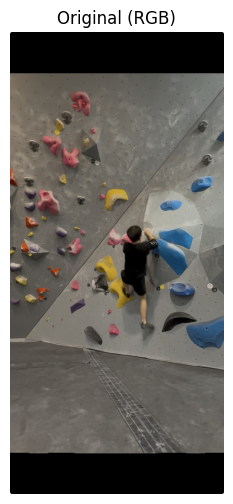

In [31]:
# Paths and image loading
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
IMG_PATH = os.path.join(DATA_PATH, "wall.jpg")
print("DATA_PATH:", DATA_PATH)
print("IMG_PATH:", IMG_PATH)

if not os.path.exists(IMG_PATH):
    print("Image not found. Please place a wall photo at:")
    print(IMG_PATH)
    display_missing = True
else:
    display_missing = False

img_bgr = None
img_rgb = None
if not display_missing:
    img_bgr = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)
    if img_bgr is None:
        print("Failed to read image. Check file permissions/format.")
    else:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8,6))
        plt.imshow(img_rgb)
        plt.title("Original (RGB)")
        plt.axis('off')
        plt.show()



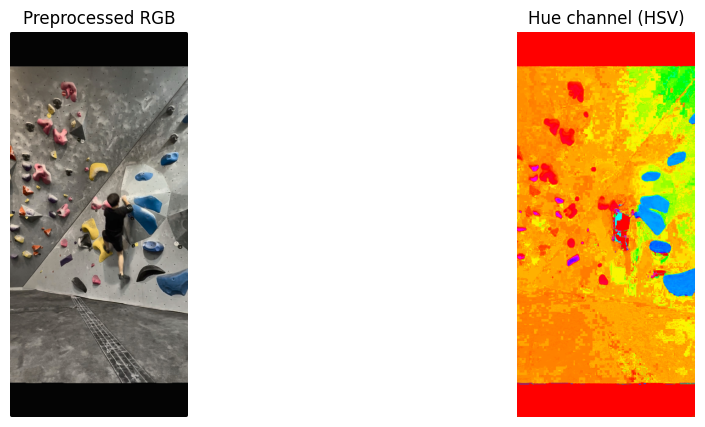

In [32]:
# Preprocess: resize (optional) and HSV + optional CLAHE on V

def apply_clahe_rgb(img_rgb: np.ndarray, clip_limit: float = 2.0, tile_grid_size: Tuple[int, int] = (8,8)) -> np.ndarray:
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_eq = clahe.apply(l)
    img_lab_eq = cv2.merge([l_eq, a, b])
    return cv2.cvtColor(img_lab_eq, cv2.COLOR_LAB2RGB)

scale = 1.0  # e.g., 0.5 to speed up
use_clahe = True

proc_rgb = None
proc_hsv = None

if img_rgb is not None:
    if scale != 1.0:
        h, w = img_rgb.shape[:2]
        proc_rgb = cv2.resize(img_rgb, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
    else:
        proc_rgb = img_rgb.copy()

    if use_clahe:
        proc_rgb = apply_clahe_rgb(proc_rgb, clip_limit=2.0, tile_grid_size=(8,8))

    proc_hsv = cv2.cvtColor(proc_rgb, cv2.COLOR_RGB2HSV)

    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].imshow(proc_rgb)
    axs[0].set_title("Preprocessed RGB")
    axs[0].axis('off')
    axs[1].imshow(proc_hsv[...,0], cmap='hsv')
    axs[1].set_title("Hue channel (HSV)")
    axs[1].axis('off')
    plt.show()
else:
    print("No image loaded to preprocess.")



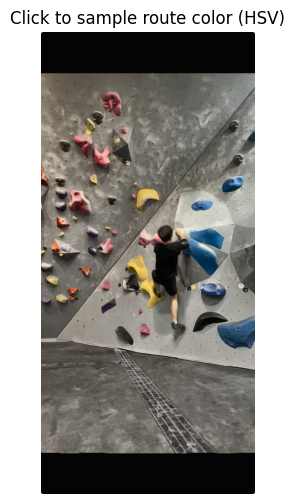

In [43]:
# Interactive calibration: eyedropper + sliders

# State for sampled HSV points
sampled_hsv: List[Tuple[int,int,int]] = []


def on_click_sample(event):
    if proc_rgb is None or proc_hsv is None:
        return
    if event.xdata is None or event.ydata is None:
        return
    x = int(event.xdata)
    y = int(event.ydata)
    h, s, v = proc_hsv[y, x].tolist()
    sampled_hsv.append((h, s, v))
    print(f"Sampled HSV at ({x},{y}):", (h, s, v))


def hsv_range_from_samples(samples: List[Tuple[int,int,int]], margin_h: int = 10, margin_sv: int = 40):
    if not samples:
        return (np.array([0, 0, 0], dtype=np.uint8), np.array([179, 255, 255], dtype=np.uint8))
    arr = np.array(samples)
    hmin, smin, vmin = np.clip(arr.min(axis=0) - np.array([margin_h, margin_sv, margin_sv]), [0,0,0], [179,255,255])
    hmax, smax, vmax = np.clip(arr.max(axis=0) + np.array([margin_h, margin_sv, margin_sv]), [0,0,0], [179,255,255])
    return (np.array([hmin, smin, vmin], dtype=np.uint8), np.array([hmax, smax, vmax], dtype=np.uint8))


if WIDGETS_OK and proc_rgb is not None:
    # Display image for clicking samples
    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    ax.imshow(proc_rgb)
    ax.set_title("Click to sample route color (HSV)")
    ax.axis('off')
    cid = fig.canvas.mpl_connect('button_press_event', on_click_sample)
    plt.show()

    # Sliders for manual adjustment
    hmin = IntSlider(description='H min', min=0, max=179, value=17)
    hmax = IntSlider(description='H max', min=0, max=179, value=58)
    smin = IntSlider(description='S min', min=0, max=255, value=83)
    smax = IntSlider(description='S max', min=0, max=255, value=202)
    vmin = IntSlider(description='V min', min=0, max=255, value=50)
    vmax = IntSlider(description='V max', min=0, max=255, value=228)
    use_samples = Checkbox(description='Use sampled range', value=True)

    out = Output()

    def update_mask(*args):
        if proc_hsv is None:
            return
        if use_samples.value and len(sampled_hsv) > 0:
            lower, upper = hsv_range_from_samples(sampled_hsv)
        else:
            lower = np.array([hmin.value, smin.value, vmin.value], dtype=np.uint8)
            upper = np.array([hmax.value, smax.value, vmax.value], dtype=np.uint8)
        mask = cv2.inRange(proc_hsv, lower, upper)
        with out:
            out.clear_output(wait=True)
            fig2, axs2 = plt.subplots(1,2, figsize=(12,5))
            axs2[0].imshow(proc_rgb)
            axs2[0].set_title("Preprocessed RGB")
            axs2[0].axis('off')
            axs2[1].imshow(mask, cmap='gray')
            axs2[1].set_title(f"Mask (lower={lower.tolist()}, upper={upper.tolist()})")
            axs2[1].axis('off')
            plt.show()

    for w in [hmin, hmax, smin, smax, vmin, vmax, use_samples]:
        w.observe(update_mask, names='value')

    controls = VBox([HBox([hmin, hmax]), HBox([smin, smax]), HBox([vmin, vmax]), use_samples])
    display(VBox([controls, out]))
    update_mask()
else:
    print("Widgets not available or image missing. Use static thresholds in the next cell.")



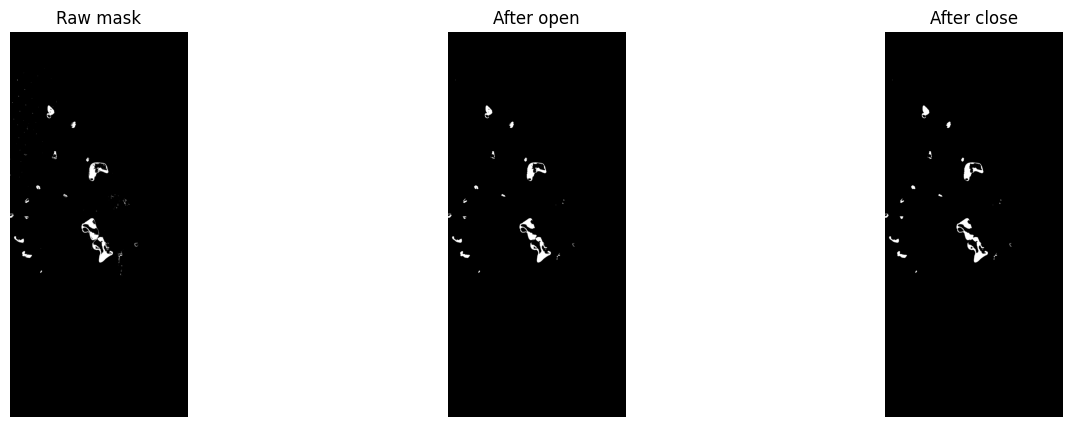

In [45]:
# Mask generation with morphology

# If widgets were unavailable, set static HSV bounds here
lower_hsv = np.array([17, 83, 50], dtype=np.uint8)
upper_hsv = np.array([58, 202, 228], dtype=np.uint8)

# If you used the interactive cell and want to reuse those bounds, you can
# re-run this cell after assigning:
# lower_hsv, upper_hsv = hsv_range_from_samples(sampled_hsv)

kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))

mask = None
if proc_hsv is not None:
    raw_mask = cv2.inRange(proc_hsv, lower_hsv, upper_hsv)
    # Optional pre-morph blur to reduce speckle
    blurred = cv2.medianBlur(raw_mask, 5)
    opened = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel_open, iterations=1)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=1)
    mask = closed

    fig, axs = plt.subplots(1,3, figsize=(16,5))
    axs[0].imshow(raw_mask, cmap='gray')
    axs[0].set_title("Raw mask")
    axs[0].axis('off')
    axs[1].imshow(opened, cmap='gray')
    axs[1].set_title("After open")
    axs[1].axis('off')
    axs[2].imshow(mask, cmap='gray')
    axs[2].set_title("After close")
    axs[2].axis('off')
    plt.show()
else:
    print("No HSV image available for masking.")



Detected components: 15


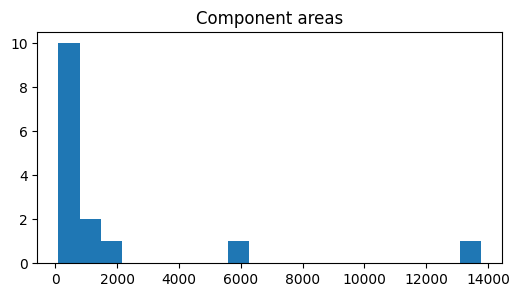

[{'area': 104.0,
  'centroid': (724, 1470),
  'bbox': (715, 1464, 22, 19),
  'aspect_ratio': 1.1578947368421053,
  'circularity': 0.2671640245797591},
 {'area': 1271.0,
  'centroid': (107, 1466),
  'bbox': (80, 1441, 64, 45),
  'aspect_ratio': 1.4222222222222223,
  'circularity': 0.4362671660805586},
 {'area': 987.5,
  'centroid': (61, 1368),
  'bbox': (27, 1344, 65, 42),
  'aspect_ratio': 1.5476190476190477,
  'circularity': 0.3255518006744495},
 {'area': 13776.5,
  'centroid': (568, 1369),
  'bbox': (470, 1224, 206, 292),
  'aspect_ratio': 0.7054794520547946,
  'circularity': 0.07552597106234095},
 {'area': 249.0,
  'centroid': (108, 1218),
  'bbox': (97, 1212, 24, 18),
  'aspect_ratio': 1.3333333333333333,
  'circularity': 0.6616324884738718}]

In [46]:
# Extract components and filter

components = []  # list of dicts with area, centroid, bbox

if mask is not None:
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 100:  # filter tiny noise
            continue
        x, y, w, h = cv2.boundingRect(cnt)
        M = cv2.moments(cnt)
        if M['m00'] == 0:
            cx, cy = x + w//2, y + h//2
        else:
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
        # Optional shape filters
        aspect = w / max(h, 1)
        perimeter = cv2.arcLength(cnt, True)
        circularity = 0.0
        if perimeter > 0:
            circularity = 4*np.pi*area/(perimeter*perimeter)
        components.append({
            'area': float(area),
            'centroid': (int(cx), int(cy)),
            'bbox': (int(x), int(y), int(w), int(h)),
            'aspect_ratio': float(aspect),
            'circularity': float(circularity),
        })

    print(f"Detected components: {len(components)}")
    if components:
        # Show histogram of areas for quick sanity check
        areas = [c['area'] for c in components]
        plt.figure(figsize=(6,3))
        plt.hist(areas, bins=20)
        plt.title('Component areas')
        plt.show()
else:
    print("No mask available.")

components[:5]



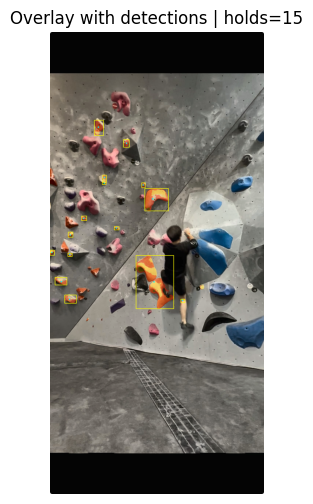

{'num_holds': 15, 'total_area': 27210.5}


In [47]:
# Visualization overlay and summary

def overlay_mask_on_rgb(rgb: np.ndarray, mask: np.ndarray, color=(0,255,0), alpha=0.4) -> np.ndarray:
    overlay = rgb.copy()
    color_img = np.zeros_like(rgb)
    color_img[:] = color
    overlay = cv2.addWeighted(color_img, alpha, overlay, 1-alpha, 0, overlay, dtype=cv2.CV_8U)
    overlay = np.where(mask[..., None] > 0, overlay, rgb)
    return overlay

summary = {}

if proc_rgb is not None and mask is not None:
    overlay = overlay_mask_on_rgb(proc_rgb, mask, color=(255,0,0), alpha=0.35)
    # Draw components
    vis = overlay.copy()
    for comp in components:
        x, y, w, h = comp['bbox']
        cx, cy = comp['centroid']
        cv2.rectangle(vis, (x,y), (x+w, y+h), (255,255,0), 2)
        cv2.circle(vis, (cx, cy), 4, (0,255,255), -1)

    num_holds = len(components)
    total_area = sum(c['area'] for c in components)
    summary = { 'num_holds': num_holds, 'total_area': float(total_area) }

    plt.figure(figsize=(12,6))
    plt.imshow(vis)
    plt.title(f"Overlay with detections | holds={num_holds}")
    plt.axis('off')
    plt.show()

    print(summary)
else:
    print("Visualization skipped; missing image or mask.")



In [48]:
# Save/export results
CONFIG_PATH = os.path.abspath(os.path.join(os.getcwd(), "..", "configs"))
EXPORT_MASK = os.path.join(DATA_PATH, "mask.png")
EXPORT_OVERLAY = os.path.join(DATA_PATH, "overlay.png")
EXPORT_CSV = os.path.join(DATA_PATH, "components.csv")
EXPORT_CFG = os.path.join(CONFIG_PATH, "color_ranges.json")

os.makedirs(CONFIG_PATH, exist_ok=True)

if mask is not None:
    cv2.imwrite(EXPORT_MASK, mask)
    print("Saved:", EXPORT_MASK)

if proc_rgb is not None and mask is not None:
    overlay = cv2.cvtColor(overlay_mask_on_rgb(proc_rgb, mask, color=(255,0,0), alpha=0.35), cv2.COLOR_RGB2BGR)
    cv2.imwrite(EXPORT_OVERLAY, overlay)
    print("Saved:", EXPORT_OVERLAY)

if components:
    import csv
    with open(EXPORT_CSV, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["area", "centroid_x", "centroid_y", "x", "y", "w", "h", "aspect_ratio", "circularity"])
        for c in components:
            (cx, cy) = c['centroid']
            (x,y,w,h) = c['bbox']
            writer.writerow([c['area'], cx, cy, x, y, w, h, c['aspect_ratio'], c['circularity']])
    print("Saved:", EXPORT_CSV)

# Persist HSV bounds
cfg = {}
if os.path.exists(EXPORT_CFG):
    try:
        with open(EXPORT_CFG, 'r') as f:
            cfg = json.load(f)
    except Exception:
        cfg = {}

cfg['last_lower_hsv'] = [int(v) for v in lower_hsv.tolist()]
cfg['last_upper_hsv'] = [int(v) for v in upper_hsv.tolist()]

with open(EXPORT_CFG, 'w') as f:
    json.dump(cfg, f, indent=2)
print("Saved:", EXPORT_CFG)



Saved: /Users/newuser/Downloads/sky-take-out/climbOcr/data/mask.png
Saved: /Users/newuser/Downloads/sky-take-out/climbOcr/data/overlay.png
Saved: /Users/newuser/Downloads/sky-take-out/climbOcr/data/components.csv
Saved: /Users/newuser/Downloads/sky-take-out/climbOcr/configs/color_ranges.json


Saved transparent PNG: /Users/newuser/Downloads/sky-take-out/climbOcr/data/exports/wall_holds_hsv.png


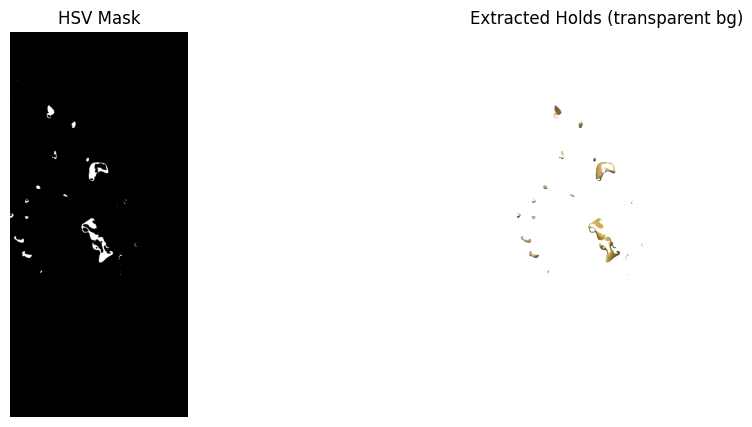

In [49]:
# Extract holds by HSV bounds and save transparent PNG (no changes to prior cells)

# Choose source RGB/HSV from existing variables
src_rgb = proc_rgb if 'proc_rgb' in globals() and proc_rgb is not None else (img_rgb if 'img_rgb' in globals() else None)
src_hsv = proc_hsv if 'proc_hsv' in globals() and proc_hsv is not None else (cv2.cvtColor(src_rgb, cv2.COLOR_RGB2HSV) if src_rgb is not None else None)

if src_rgb is None or src_hsv is None:
    print("No image available. Ensure earlier cells loaded and preprocessed the image.")
else:
    # Mask from provided HSV bounds
    mask_hsv = cv2.inRange(src_hsv, lower_hsv, upper_hsv)

    # Optional light cleanup (does not modify prior cells)
    k_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    k_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    mask_clean = cv2.morphologyEx(mask_hsv, cv2.MORPH_OPEN, k_open, iterations=1)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, k_close, iterations=1)

    # Build RGBA with blank background
    h, w = mask_clean.shape
    rgba = np.zeros((h, w, 4), dtype=np.uint8)
    rgba[..., :3] = src_rgb
    rgba[..., 3] = (mask_clean > 0).astype(np.uint8) * 255

    # Save to exports
    export_dir = os.path.join(DATA_PATH if 'DATA_PATH' in globals() else os.path.dirname(IMG_PATH), 'exports')
    os.makedirs(export_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(IMG_PATH if 'IMG_PATH' in globals() else 'image'))[0]
    out_path = os.path.join(export_dir, f"{base}_holds_hsv.png")
    cv2.imwrite(out_path, cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA))
    print("Saved transparent PNG:", out_path)

    # Quick view
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    axs[0].imshow(mask_clean, cmap='gray'); axs[0].set_title('HSV Mask'); axs[0].axis('off')
    axs[1].imshow(rgba); axs[1].set_title('Extracted Holds (transparent bg)'); axs[1].axis('off')
    plt.show()